In [1]:
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings

import numpy as np
import matplotlib.pyplot as plt
from agentic_energy.heuristics.heuristic_trader import HeuristicTrader, records_to_arrays
from agentic_energy.data_loader import EnergyDataLoader
from agentic_energy.schemas import BatteryParams, DayInputs, SolveRequest

2025-10-16 20:38:32.259 | DEBUG    | agentics.core.llm_connections:<module>:121 - AGENTICS is connecting to the following LLM API providers:
2025-10-16 20:38:32.260 | DEBUG    | agentics.core.llm_connections:<module>:129 - 0 - Gemini
2025-10-16 20:38:32.260 | DEBUG    | agentics.core.llm_connections:<module>:133 - 1 - OpenAI
2025-10-16 20:38:32.260 | DEBUG    | agentics.core.llm_connections:<module>:135 - Please add API keys in .env file to add or disconnect providers.
2025-10-16 20:38:32.271 | DEBUG    | agentics.core.llm_connections:get_llm_provider:29 - No LLM provider specified. Using the first available provider.
2025-10-16 20:38:32.271 | DEBUG    | agentics.core.llm_connections:get_llm_provider:31 - Available LLM providers: ['gemini', 'openai']. Using 'gemini'


In [2]:
italy_obj = EnergyDataLoader(region="ITALY")
italy_data = italy_obj.load_region_data()

2025-10-16 20:38:32.289 | DEBUG    | agentics.core.agentics:from_csv:312 - Importing Agentics of type EnergyDataRecord from CSV /Users/millendroy/Projects/Agentic_Energy/Agentics_for_EnergyArbitrage_Battery/energy_arbitrage/agentic_energy/data/Italy_data_actual.csv


In [3]:
italy_data[0]

EnergyDataRecord(timestamps='2018-01-01 00:00:00', prices=45.82, consumption=22.98, year=None, region='ITALY', decisions=None)

In [4]:
stats= await EnergyDataLoader.get_summary_stats_from_ag(italy_data)
print(stats.pretty_print())

Atype : <class 'agentic_energy.schemas.SummaryStats'>
region: ITALY
total_records: 17518
date_range:
  start: '2018-01-01 00:00:00'
  end: '2019-12-31 23:00:00'
prices:
  count: 17518
  min: 1.0
  max: 159.4
  avg: 56.81830574266469
  median: 55.99
  p25: 46.662499999999994
  p75: 66.13
  std: 14.514075376488504
  var: 210.6583840343899
consumption:
  count: 17518
  min: 18.85
  max: 50.31
  avg: 33.148212124671765
  median: 32.65
  p25: 26.96
  p75: 39.32
  std: 6.92811417513687
  var: 47.998766023732436




In [5]:
batterydetails = BatteryParams(
    capacity_kwh=49.44,
    cmax_kw=12.36,
    dmax_kw=12.36,
    soc_init=0.5,
    soc_min=0.0,
    soc_max=1.0,
    eta_c=0.95,
    eta_d=0.95,
    soc_target=0.5,
)

In [6]:
trader_time = HeuristicTrader(
        mode="time",
        charge_windows=[(2, 6), (10, 16), (20, 22)],
        discharge_windows=[(0, 2), (6, 10), (16, 20), (22, 24)],
    )
trader_quant = HeuristicTrader(
        mode="quantile",
        low_q=0.30,
        high_q=0.70,
    )

In [7]:
results_time = []
day_info_time = []
decision_list_time = []
soc_list_time = []
num_days = len(italy_data) // 24
bat_time = batterydetails.copy(deep=True)
for i in range(num_days):
        print(f"[TIME] Solving day {i+1}/{num_days}")
        day_records = italy_data[i * 24 : (i + 1) * 24]
        prices, demand = records_to_arrays(day_records)
        day = DayInputs(
            prices_buy=prices,
            prices_sell=prices,
            demand_kw=demand,
            allow_export=True,
            dt_hours=1.0,
        )

        day_info_time.append(day)

        req=SolveRequest(
            battery=bat_time,
            day = day,
            solver = None,
            solver_opts={"mode": "time"},
        )

        result = trader_time.solve(req)
        results_time.append(result)

        # Stitch SoC: use last SoC (fractional) from the day as next day's init
        if result.soc and len(result.soc) > 0:
            # Avoid duplicating the last point in per-step ladders
            soc_list_time += result.soc[:-1]
            bat_time.soc_init = float(result.soc[-1])
        else:
            # If solver returned empty SoC (shouldn't happen), keep previous init
            pass

        # Accumulate decisions
        if result.decision:
            decision_list_time += result.decision

        # Optional: show day summary
        print(f"  Objective cost (day {i+1}): {result.objective_cost:.4f}")

total_cost_time = float(np.nansum([r.objective_cost for r in results_time]))
print(f"=== TIME windows summary ===")
print(f"Total objective cost over all days: {total_cost_time:.4f}  (negative = profit)")

[TIME] Solving day 1/729
  Objective cost (day 1): 25836.9850
[TIME] Solving day 2/729
  Objective cost (day 2): 42683.2253
[TIME] Solving day 3/729
  Objective cost (day 3): 85776.6043
[TIME] Solving day 4/729
  Objective cost (day 4): 17484.9017
[TIME] Solving day 5/729
  Objective cost (day 5): 23915.3152
[TIME] Solving day 6/729
  Objective cost (day 6): 53167.3301
[TIME] Solving day 7/729
  Objective cost (day 7): 38074.3829
[TIME] Solving day 8/729
  Objective cost (day 8): 72748.7144
[TIME] Solving day 9/729
  Objective cost (day 9): 49188.9449
[TIME] Solving day 10/729
  Objective cost (day 10): 59921.3435
[TIME] Solving day 11/729
  Objective cost (day 11): 38282.1862
[TIME] Solving day 12/729
  Objective cost (day 12): 53225.1391
[TIME] Solving day 13/729
  Objective cost (day 13): 36679.7165
[TIME] Solving day 14/729
  Objective cost (day 14): 33160.8479
[TIME] Solving day 15/729
  Objective cost (day 15): 45887.9635
[TIME] Solving day 16/729
  Objective cost (day 16): 45700

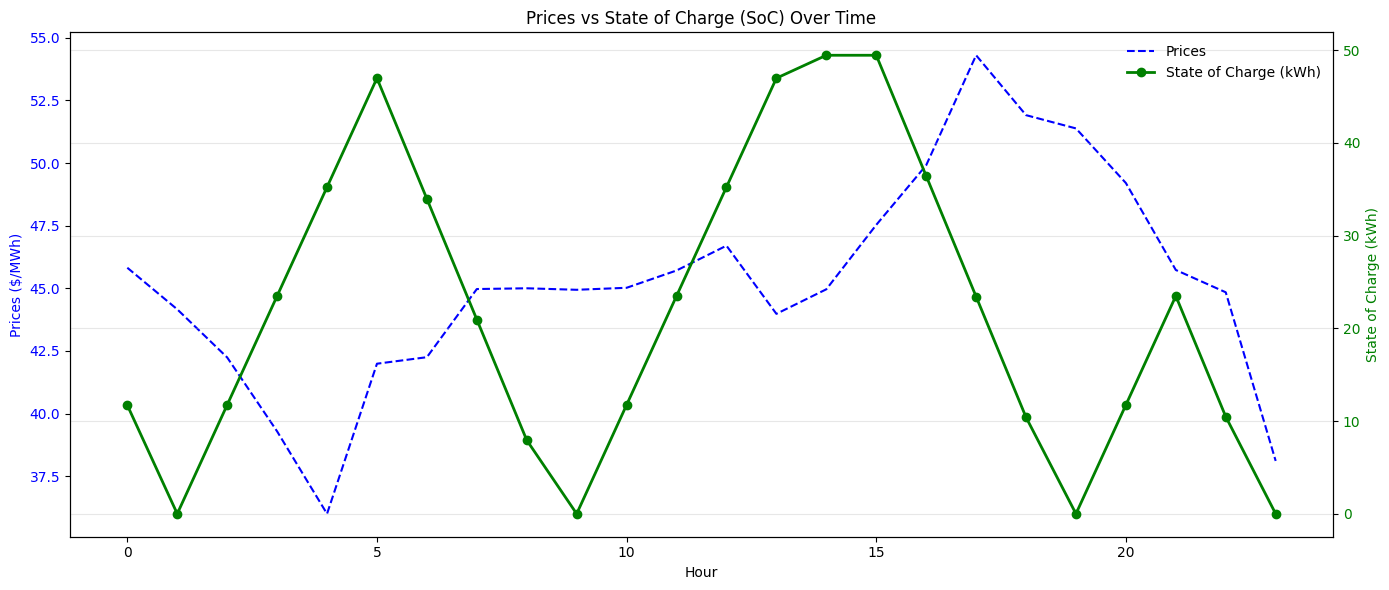

In [8]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Primary axis (Prices) ---
ax1.plot(hours, day_info_time[0].prices_buy, '--b', label='Prices')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Prices ($/MWh)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# --- Secondary axis (State of Charge) ---
ax2 = ax1.twinx()
ax2.plot(hours, np.array(results_time[0].soc) * bat_time.capacity_kwh,
         '-og', label='State of Charge (kWh)', linewidth=2, markersize=6)
ax2.set_ylabel('State of Charge (kWh)', color='g')
ax2.tick_params(axis='y', labelcolor='g')


# --- Legends ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best', frameon=False)

plt.title('Prices vs State of Charge (SoC) Over Time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


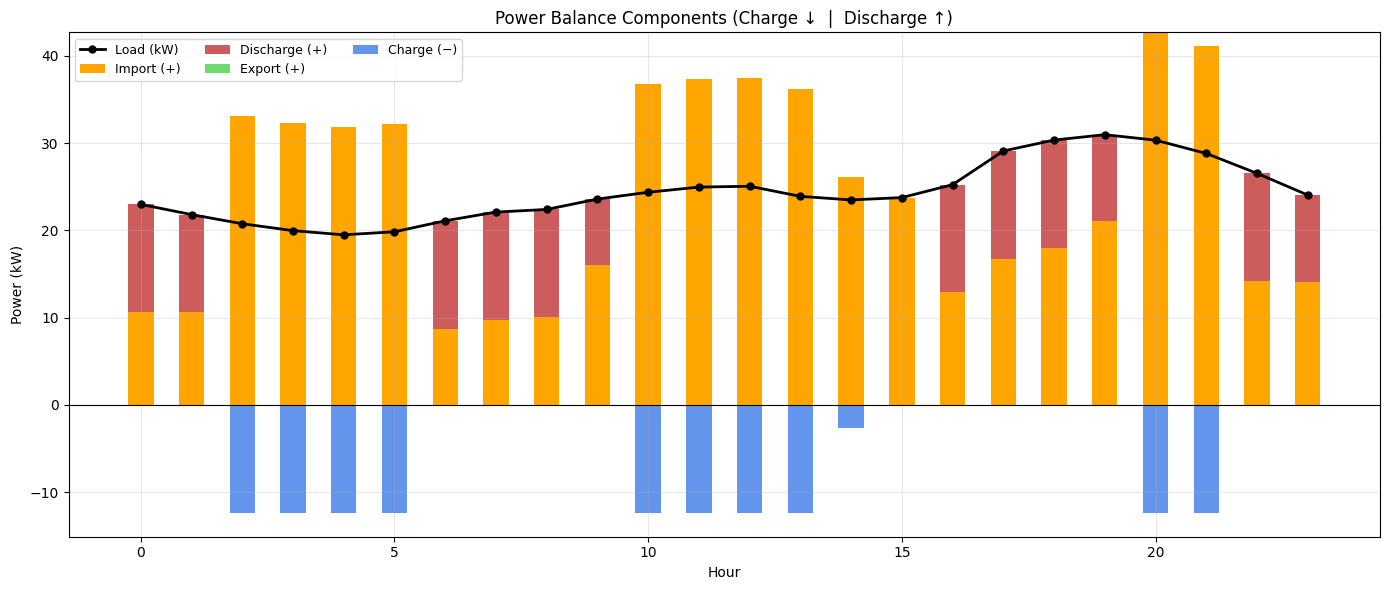

In [9]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)

# Data arrays
load = np.array(day_info_time[0].demand_kw)
charge = np.array(results_time[0].charge_kw)
discharge = np.array(results_time[0].discharge_kw)
import_kw = np.array(results_time[0].import_kw)
export_kw = np.array(results_time[0].export_kw) if getattr(day_info_time[0], "allow_export", False) else np.zeros_like(load)

# Flip battery convention for visualization
charge_vis = -charge       # show charge below 0
discharge_vis = discharge  # show discharge above 0

# ---------------------- PLOT ----------------------
fig, ax = plt.subplots(figsize=(14, 6))

# --- positive side stacking (Import + Discharge + Export) ---
# import is base layer
ax.bar(hours, import_kw, width=0.5, color='orange', label='Import (+)')
# discharge stacked on top of import
ax.bar(hours, discharge_vis, width=0.5, bottom=import_kw, color='indianred', label='Discharge (+)')
# export stacked on top (for clear separation)
ax.bar(hours, export_kw, width=0.5, bottom=import_kw + discharge_vis, color='limegreen', alpha=0.7, label='Export (+)')

# --- negative side stacking (Charge only) ---
ax.bar(hours, charge_vis, width=0.5, color='cornflowerblue', label='Charge (−)')

# --- Load as line ---
ax.plot(hours, load, '-ok', linewidth=2, markersize=5, label='Load (kW)')

# Formatting
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel("Power (kW)")
ax.set_xlabel("Hour")
ax.set_title("Power Balance Components (Charge ↓  |  Discharge ↑)")
ax.legend(ncol=3, loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
results_quantile = []
day_info_quantile = []
decision_list_quantile = []
soc_list_quantile = []
num_days = len(italy_data) // 24
bat_quantile = batterydetails.copy(deep=True)
for i in range(num_days):
        print(f"[TIME] Solving day {i+1}/{num_days}")
        day_records = italy_data[i * 24 : (i + 1) * 24]
        prices, demand = records_to_arrays(day_records)
        day = DayInputs(
            prices_buy=prices,
            prices_sell=prices,
            demand_kw=demand,
            allow_export=True,
            dt_hours=1.0,
        )

        day_info_quantile.append(day)

        req=SolveRequest(
            battery=bat_quantile,
            day = day,
            solver = None,
            solver_opts={"mode": "quantile"},
        )

        result = trader_quant.solve(req)
        results_quantile.append(result)

        # Stitch SoC: use last SoC (fractional) from the day as next day's init
        if result.soc and len(result.soc) > 0:
            # Avoid duplicating the last point in per-step ladders
            soc_list_quantile += result.soc[:-1]
            bat_quantile.soc_init = float(result.soc[-1])
        else:
            # If solver returned empty SoC (shouldn't happen), keep previous init
            pass

        # Accumulate decisions
        if result.decision:
            decision_list_quantile += result.decision

        # Optional: show day summary
        print(f"  Objective cost (day {i+1}): {result.objective_cost:.4f}")

total_cost_quantile = float(np.nansum([r.objective_cost for r in results_quantile]))
print(f"=== Quantile windows summary ===")
print(f"Total objective cost over all days: {total_cost_quantile:.4f}  (negative = profit)")

[TIME] Solving day 1/729
  Objective cost (day 1): 25900.2359
[TIME] Solving day 2/729
  Objective cost (day 2): 42481.7022
[TIME] Solving day 3/729
  Objective cost (day 3): 84533.1664
[TIME] Solving day 4/729
  Objective cost (day 4): 15311.8422
[TIME] Solving day 5/729
  Objective cost (day 5): 22998.7193
[TIME] Solving day 6/729
  Objective cost (day 6): 52302.7835
[TIME] Solving day 7/729
  Objective cost (day 7): 36479.9147
[TIME] Solving day 8/729
  Objective cost (day 8): 72007.1460
[TIME] Solving day 9/729
  Objective cost (day 9): 48308.6894
[TIME] Solving day 10/729
  Objective cost (day 10): 59604.5587
[TIME] Solving day 11/729
  Objective cost (day 11): 38640.3586
[TIME] Solving day 12/729
  Objective cost (day 12): 53488.7102
[TIME] Solving day 13/729
  Objective cost (day 13): 35515.8776
[TIME] Solving day 14/729
  Objective cost (day 14): 32435.8854
[TIME] Solving day 15/729
  Objective cost (day 15): 45543.7131
[TIME] Solving day 16/729
  Objective cost (day 16): 46163

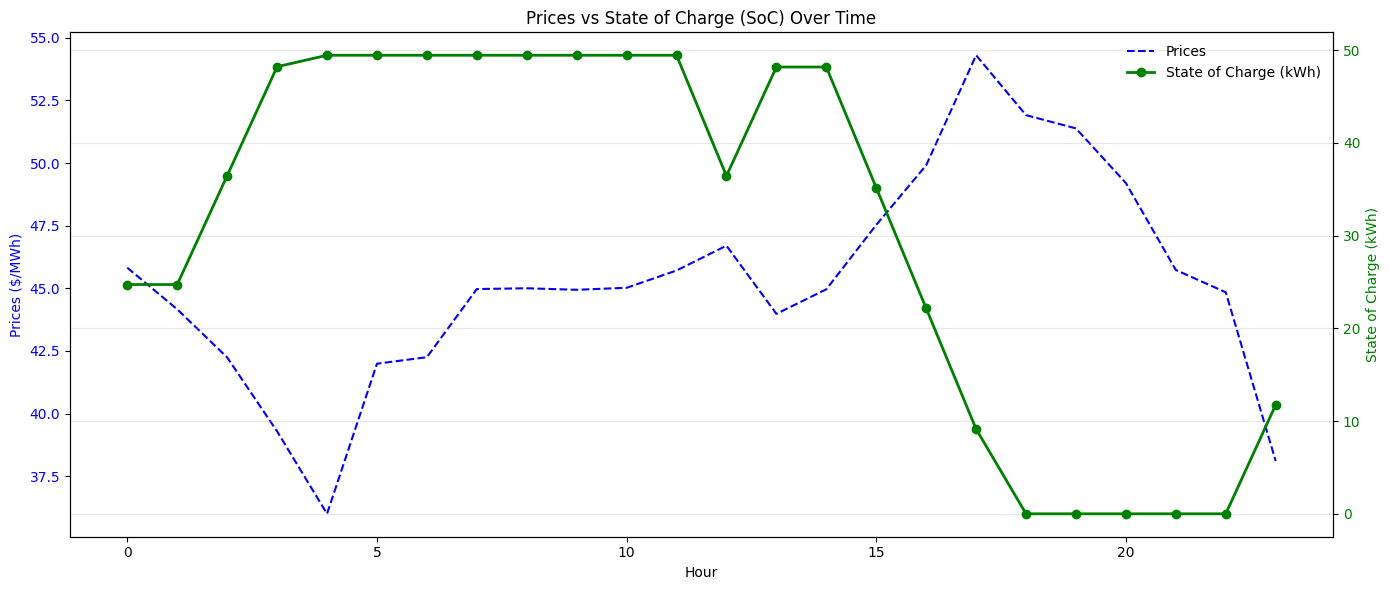

In [11]:
hours = np.arange(24)
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Primary axis (Prices) ---
ax1.plot(hours, day_info_quantile[0].prices_buy, '--b', label='Prices')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Prices ($/MWh)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# --- Secondary axis (State of Charge) ---
ax2 = ax1.twinx()
ax2.plot(hours, np.array(results_quantile[0].soc) * bat_quantile.capacity_kwh,
         '-og', label='State of Charge (kWh)', linewidth=2, markersize=6)
ax2.set_ylabel('State of Charge (kWh)', color='g')
ax2.tick_params(axis='y', labelcolor='g')


# --- Legends ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best', frameon=False)

plt.title('Prices vs State of Charge (SoC) Over Time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
results_quantile[0].objective_cost, results_time[0].objective_cost

(25900.23585573684, 25836.98497063158)

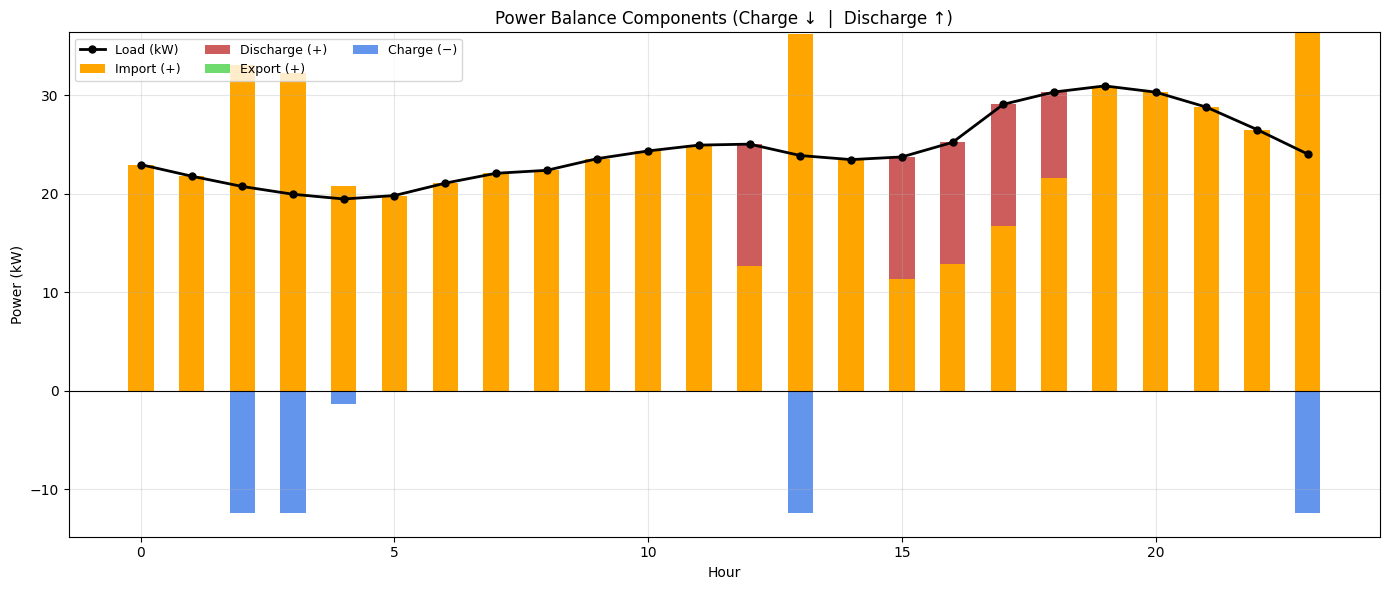

In [13]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)

# Data arrays
load = np.array(day_info_quantile[0].demand_kw)
charge = np.array(results_quantile[0].charge_kw)
discharge = np.array(results_quantile[0].discharge_kw)
import_kw = np.array(results_quantile[0].import_kw)
export_kw = np.array(results_quantile[0].export_kw) if getattr(day_info_quantile[0], "allow_export", False) else np.zeros_like(load)

# Flip battery convention for visualization
charge_vis = -charge       # show charge below 0
discharge_vis = discharge  # show discharge above 0

# ---------------------- PLOT ----------------------
fig, ax = plt.subplots(figsize=(14, 6))

# --- positive side stacking (Import + Discharge + Export) ---
# import is base layer
ax.bar(hours, import_kw, width=0.5, color='orange', label='Import (+)')
# discharge stacked on top of import
ax.bar(hours, discharge_vis, width=0.5, bottom=import_kw, color='indianred', label='Discharge (+)')
# export stacked on top (for clear separation)
ax.bar(hours, export_kw, width=0.5, bottom=import_kw + discharge_vis, color='limegreen', alpha=0.7, label='Export (+)')

# --- negative side stacking (Charge only) ---
ax.bar(hours, charge_vis, width=0.5, color='cornflowerblue', label='Charge (−)')

# --- Load as line ---
ax.plot(hours, load, '-ok', linewidth=2, markersize=5, label='Load (kW)')

# Formatting
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel("Power (kW)")
ax.set_xlabel("Hour")
ax.set_title("Power Balance Components (Charge ↓  |  Discharge ↑)")
ax.legend(ncol=3, loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
